negsamples shape: (24, 24, 17256)
possamples shape: (24, 24, 4000)


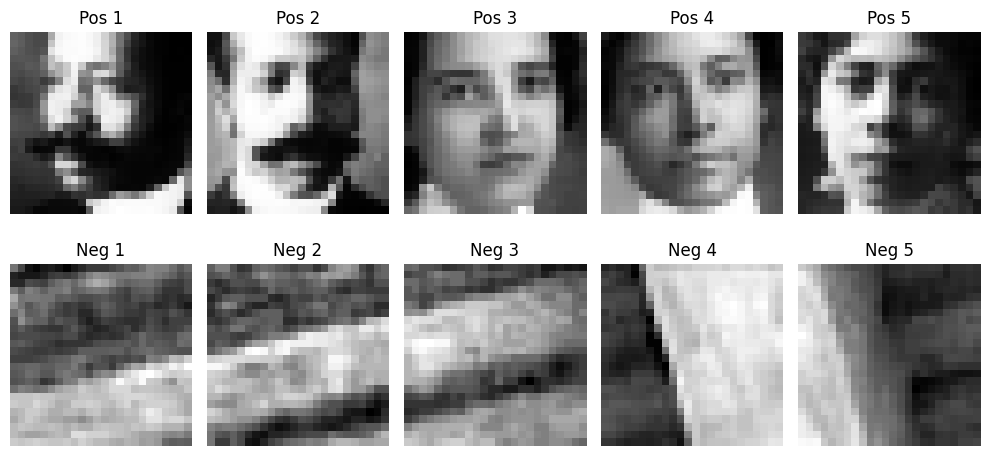

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
# Lấy thư mục hiện tại (nơi file .py hoặc .ipynb đang chạy)
base_dir = os.getcwd()  

# Ghép đường dẫn động
pos_path = os.path.join(base_dir, "possamples.mat")
neg_path = os.path.join(base_dir, "negsamples.mat")

# Load file
possamples = loadmat(pos_path)["possamples"]
negsamples = loadmat(neg_path)["negsamples"]

print(f"negsamples shape: {negsamples.shape}")
print(f"possamples shape: {possamples.shape}")
# Vẽ 5 ảnh đầu tiên trong possamples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)  # Hàng đầu tiên
    plt.imshow(possamples[:, :, i], cmap='gray')
    plt.axis("off")
    plt.title(f"Pos {i+1}")

# Vẽ 5 ảnh đầu tiên trong negsamples
for i in range(5):
    plt.subplot(2, 5, i+6)  # Hàng thứ hai
    plt.imshow(negsamples[:, :, i], cmap='gray')
    plt.axis("off")
    plt.title(f"Neg {i+1}")

plt.tight_layout()
plt.show()

In [2]:
# Step 1: Load data from files
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
data_pos = loadmat('possamples.mat')
data_neg = loadmat('negsamples.mat')
possamples = data_pos['possamples']  # 4000 samples
reduced_negsamples = data_neg['negsamples'][:, :, :8000]  # Limit to 8000 samples

# Ensure randomness for each sample set
np.random.seed(42)  
pos_indices = np.random.permutation(possamples.shape[2])
neg_indices = np.random.permutation(reduced_negsamples.shape[2])

# Step 2: Calculate the number of samples for each set
train_size_pos = int( possamples.shape[2])


train_size_neg = int( reduced_negsamples.shape[2])


# Step 3: Split data according to randomized indices
X_train = np.concatenate((possamples[:, :, pos_indices[:train_size_pos]], 
                          reduced_negsamples[:, :, neg_indices[:train_size_neg]]), axis=2)
y_train = np.concatenate((np.ones(train_size_pos), np.zeros(train_size_neg)))

# Check the shapes of each set
print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)

Shapes:
X_train: (24, 24, 12000) y_train: (12000,)


Shape of HOG features - Train: (12000, 1296)


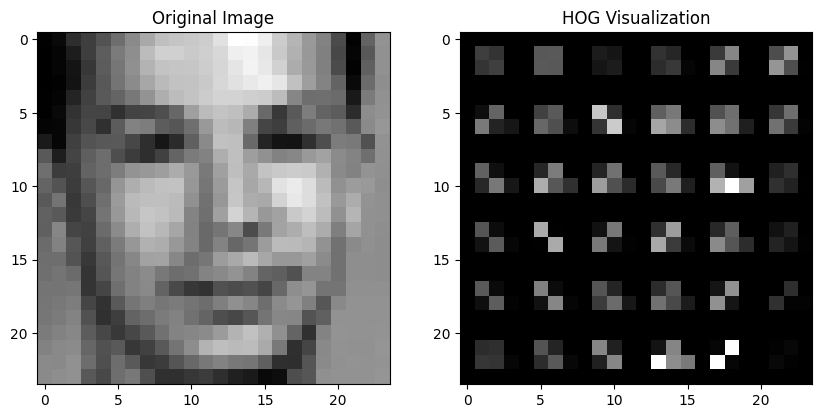

In [3]:
from skimage.feature import hog
from concurrent.futures import ThreadPoolExecutor

# Trích xuất đặc trưng HOG
def extract_hog_features(X):
    pixels_per_cell, cells_per_block, orientations = get_hog_parameters(X.shape[0])
    with ThreadPoolExecutor() as executor:
        hog_features = list(executor.map(lambda img: hog(
            (img - np.min(img)) / (np.max(img) - np.min(img)),
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys'), 
            [X[:, :, i] for i in range(X.shape[2])]))
    return np.array(hog_features)

# Định nghĩa tham số HOG theo kích thước ảnh
def get_hog_parameters(image_size):
    return (4, 4), (3, 3), 9

# Hiển thị đặc trưng HOG của một ảnh
def visualize_hog(image):
    normalized_img = (image - np.min(image)) / (np.max(image) - np.min(image))
    features, hog_img = hog(normalized_img, orientations=9, pixels_per_cell=(4, 4),
                            cells_per_block=(3, 3), block_norm='L2-Hys', visualize=True)
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original Image')
    plt.subplot(122), plt.imshow(hog_img, cmap='gray'), plt.title('HOG Visualization')
    plt.show()
    return features, hog_img

# Sử dụng HOG cho các tập train và validation
X_train_hog = extract_hog_features(X_train)
print("Shape of HOG features - Train:", X_train_hog.shape)

# Hiển thị đặc trưng HOG cho một ảnh mẫu
sample_image = X_train[:, :, 0]
features, hog_image = visualize_hog(sample_image)


In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Tạo dictionary chứa các tham số cần tìm
param_grid = {
    'C': [0.1, 0.6, 1, 3, 5],  
    'gamma': ['scale'], 
    'kernel': ['rbf', 'poly']  
}

# Khởi tạo mô hình SVM
svm = SVC()

# Dùng GridSearchCV để tìm bộ tham số tốt nhất
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_hog, y_train)

# Lấy mô hình tốt nhất và tham số tốt nhất
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_  

# In kết quả
print("Best model parameters:", best_params)
print(f"Best cross-validation score: {best_cv_score:.4f}")




Best model parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 0.9940


# Try with real picture

In [5]:
import cv2

# Load the original image

# Lấy thư mục hiện tại (nơi file đang chạy)
base_dir = os.getcwd()

# Tạo đường dẫn tới file ảnh
image_path = os.path.join(base_dir, "z5975965490289_94467b312d61239a6991465b90456adf.jpg")
original_image = cv2.imread(image_path)

# Set the desired size for the sub-images
sub_image_size = (48, 48)

# Get the dimensions of the original image
height, width, _ = original_image.shape

# Initialize a list to store the sub-images
sub_images = []

# Define step size for sliding window
step_size = 6  # Bạn có thể điều chỉnh kích thước bước nhảy

# Loop through the original image and extract sub-images using sliding window
for y in range(0, height - sub_image_size[1] + 1, step_size):
    for x in range(0, width - sub_image_size[0] + 1, step_size):
        sub_image = original_image[y:y + sub_image_size[1], x:x + sub_image_size[0]]
        sub_images.append(sub_image)


# Chuyển đổi tất cả các ảnh trong sub_images thành kích thước 24x24
sub_images_resized = []

for sub_image in sub_images:
    resized_image = cv2.resize(sub_image, (24, 24), interpolation=cv2.INTER_AREA)
    sub_images_resized.append(resized_image)

# Chuyển sub_images_resized thành mảng NumPy để dễ xử lý và xem kích thước
sub_images_resized = np.array(sub_images_resized)

# Kiểm tra kích thước của mảng sau khi thu nhỏ
print(f'sub_images_resized shape: {sub_images_resized.shape}')

sub_images_resized shape: (18952, 24, 24, 3)


In [6]:
from skimage.color import rgb2gray

# Giả sử sub_images_resized là mảng hình ảnh của bạn
sub_images_resized_gray = rgb2gray(sub_images_resized)

# Kiểm tra hình dạng của mảng sau khi chuyển đổi
print("Shape after conversion to grayscale:", sub_images_resized_gray.shape)


Shape after conversion to grayscale: (18952, 24, 24)


In [7]:
from skimage.color import rgb2gray
from skimage.feature import hog

# Chuyển đổi mảng hình ảnh sang ảnh xám
sub_images_resized_gray = rgb2gray(sub_images_resized)

# Kiểm tra hình dạng của mảng sau khi chuyển đổi
print("Shape after conversion to grayscale:", sub_images_resized_gray.shape)

# Hàm để trích xuất đặc trưng HOG từ hình ảnh xám
def extract_hog_features(X):
    # Số lượng ảnh
    n_samples = X.shape[0]
    
    # Tham số HOG
    pixels_per_cell = (4, 4)  # Kích thước cell
    cells_per_block = (3, 3)  # Số cell trong một block
    orientations = 9  # Số hướng gradient
    
    # Khởi tạo mảng để lưu đặc trưng HOG
    hog_features = []
    
    # Trích xuất HOG cho từng ảnh
    for i in range(n_samples):
        image = X[i]  # Ảnh của bạn ở định dạng (24, 24)
        
        # Trích xuất đặc trưng HOG
        features = hog(image, 
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys',
                       visualize=False)
        
        hog_features.append(features)
    
    return np.array(hog_features)

# Áp dụng HOG cho tập dữ liệu đã chuyển sang ảnh xám
X_hog_features = extract_hog_features(sub_images_resized_gray)

# Kiểm tra kích thước của đặc trưng HOG cho dữ liệu mới
print("Shape of HOG features - New Data:", X_hog_features.shape)


Shape after conversion to grayscale: (18952, 24, 24)
Shape of HOG features - New Data: (18952, 1296)


In [8]:
# Dự đoán cho tập kiểm tra
data_pred = best_model.predict(X_hog_features)

# Lấy độ tin cậy cho dự đoán
if hasattr(best_model, "decision_function"):
    confidence_scores = best_model.decision_function(X_hog_features)
elif hasattr(best_model, "predict_proba"):
    probability_scores = best_model.predict_proba(X_hog_features)
    confidence_scores = probability_scores[:, 1]  # Chọn xác suất cho lớp 1

# Đếm số lượng ảnh được dự đoán là mặt người
predicted_face_indices = np.where(data_pred == 1)[0]  # Giả sử lớp 1 là mặt người
num_faces_predicted = len(predicted_face_indices)

# Chọn những ảnh có độ tin cậy >= 90%
reliable_face_indices_test = np.where(confidence_scores >= 0.9)[0]
num_reliable_faces = len(reliable_face_indices_test)

# In ra kết quả
print(f"Có tổng cộng {num_faces_predicted} ảnh được dự đoán là mặt người.")
print(f"Có {num_reliable_faces} ảnh được xác định là mặt người với độ tin cậy >= 90%.")


Có tổng cộng 215 ảnh được dự đoán là mặt người.
Có 58 ảnh được xác định là mặt người với độ tin cậy >= 90%.


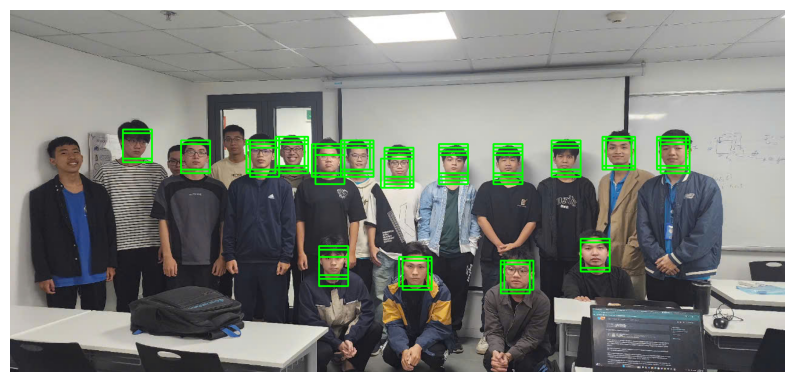

In [11]:
# Load lại ảnh gốc (để đảm bảo không bị chỉnh sửa từ trước)

# Lấy thư mục hiện tại (nơi file đang chạy)
base_dir = os.getcwd()

# Tạo đường dẫn tới file ảnh
image_path = os.path.join(base_dir, "z5975965490289_94467b312d61239a6991465b90456adf.jpg")
original_image = cv2.imread(image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB để hiển thị đúng màu với matplotlib

# Kích thước và bước của sub-image
sub_image_size = (48, 48)
step_size = 6

# Duyệt qua các vị trí của sliding window và vẽ viền xanh nếu được xác định là mặt người với độ tin cậy >= 90%
face_idx = 0
for y in range(0, original_image.shape[0] - sub_image_size[1] + 1, step_size):
    for x in range(0, original_image.shape[1] - sub_image_size[0] + 1, step_size):
        # Kiểm tra nếu sub-image hiện tại được xác định là mặt người
        if data_pred[face_idx] == 1 and confidence_scores[face_idx] >= 0.9:  # Kiểm tra độ tin cậy
            # Vẽ hình chữ nhật màu xanh xung quanh sub-image
            top_left = (x, y)
            bottom_right = (x + sub_image_size[0], y + sub_image_size[1])
            cv2.rectangle(original_image_rgb, top_left, bottom_right, (0, 255, 0), 2)  # Viền màu xanh lá cây
        face_idx += 1

# Hiển thị ảnh với các khung hình chữ nhật xung quanh sub-images dự đoán là mặt người
plt.figure(figsize=(10, 10))
plt.imshow(original_image_rgb)
plt.axis('off')
plt.show()


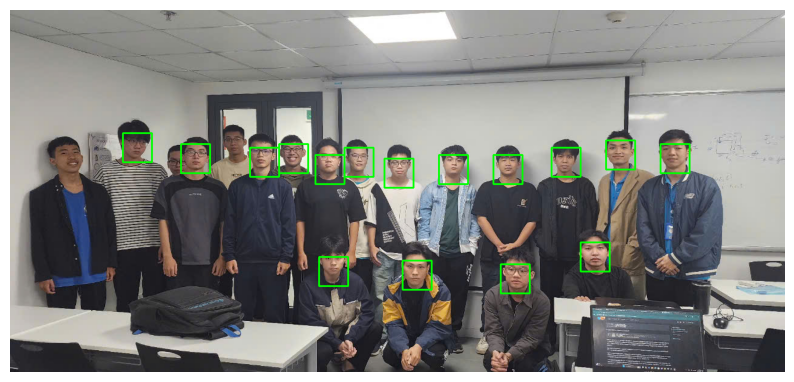

In [12]:
from matplotlib import pyplot as plt

def non_max_suppression(boxes, scores, iou_threshold):
    # Sắp xếp boxes theo điểm số từ cao đến thấp
    order = np.argsort(scores)[::-1]
    keep = []
    
    while order.size > 0:
        # Lấy box có điểm số cao nhất
        current = order[0]
        keep.append(current)
        
        # Tính IoU với tất cả các box còn lại
        xx1 = np.maximum(boxes[current][0], boxes[order[1:]][:,0])
        yy1 = np.maximum(boxes[current][1], boxes[order[1:]][:,1])
        xx2 = np.minimum(boxes[current][2], boxes[order[1:]][:,2])
        yy2 = np.minimum(boxes[current][3], boxes[order[1:]][:,3])
        
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        
        # Tính diện tích của các box
        area_current = (boxes[current][2] - boxes[current][0] + 1) * \
                      (boxes[current][3] - boxes[current][1] + 1)
        area_other = (boxes[order[1:]][:,2] - boxes[order[1:]][:,0] + 1) * \
                    (boxes[order[1:]][:,3] - boxes[order[1:]][:,1] + 1)
        
        # Tính IoU
        iou = inter / (area_current + area_other - inter)
        
        # Loại bỏ các box có IoU lớn hơn ngưỡng
        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]
    
    return keep

# Load lại ảnh gốc
original_image = cv2.imread(image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Kích thước và bước của sub-image
sub_image_size = (48, 48)
step_size = 6

# Tạo danh sách các box và điểm số tương ứng
boxes = []
scores = []
face_idx = 0

for y in range(0, original_image.shape[0] - sub_image_size[1] + 1, step_size):
    for x in range(0, original_image.shape[1] - sub_image_size[0] + 1, step_size):
        if data_pred[face_idx] == 1 and confidence_scores[face_idx] >= 0.9:
            # Thêm box và điểm số
            boxes.append([x, y, x + sub_image_size[0], y + sub_image_size[1]])
            scores.append(1.0)  # Nếu có confidence scores, thay thế 1.0 bằng scores thực tế
        face_idx += 1

# Chuyển sang numpy array
boxes = np.array(boxes)
scores = np.array(scores)

# Áp dụng NMS
if len(boxes) > 0:
    keep_indices = non_max_suppression(boxes, scores, iou_threshold=0.25)
    
    # Vẽ các box đã được lọc
    for idx in keep_indices:
        top_left = (boxes[idx][0], boxes[idx][1])
        bottom_right = (boxes[idx][2], boxes[idx][3])
        cv2.rectangle(original_image_rgb, top_left, bottom_right, (0, 255, 0), 2)

# Hiển thị kết quả
plt.figure(figsize=(10, 10))
plt.imshow(original_image_rgb)
plt.axis('off')
plt.show()